# Efficient Byte-Pair Encoding Algorithms

Byte pair encoding example
Suppose the data to be encoded is

`aaabdaaabac`

The byte pair "aa" occurs most often, so it will be replaced by a byte that is not used in the data, "Z". Now there is the following data and replacement table:

`ZabdZabac`

```
Z -> aa
```

Then the process is repeated with byte pair "ab", replacing it with Y:

`ZYdZYac`

```
Y -> ab
Z -> aa
```

The only literal byte pair left occurs only once, and the encoding might stop here. Or the process could continue with recursive byte pair encoding, replacing "ZY" with "X":

`XdXac`

```
X -> ZY
Y -> ab
Z -> aa
```

References:

- [Neural Machine Translation of Rare Words with Subword Units](https://aclanthology.org/P16-1162.pdf)

- https://en.wikipedia.org/wiki/Byte_pair_encoding

- https://www.derczynski.com/papers/archive/BPE_Gage.pdf


Data:
- https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip

In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
from arsenal import Integerizer, colors, iterview, timeit, timers
from arsenal.iterextras import flatten, take, window
from collections import Counter, defaultdict
from pprint import pprint
from bpe import FastBPE, SlowBPE, merge

In [13]:
xs = list('aaaabdaaabac')

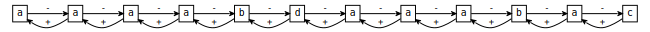

In [14]:
FastBPE(xs).to_graph().graphviz({'rankdir': 'LR'})

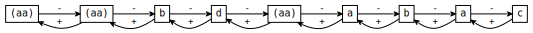

In [15]:
FastBPE(xs).merge(('a', 'a')).to_graph().graphviz({'rankdir': 'LR'})

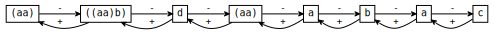

In [16]:
FastBPE(xs).merge(('a','a')).merge((('a','a'), 'b')).to_graph().graphviz({'rankdir': 'LR'})

In [ ]:
def _reference(xs):
    if len(xs) <= 1: return xs
    c = Counter(window(xs, 2))
    pair, _ = c.most_common()[0]
    return merge(xs, pair)

In [ ]:
_reference(xs)

In [ ]:
ys = _reference(_reference(_reference(xs)))
assert xs == list(flatten(xs))
ys

In [ ]:
def greedy(xs, T=None):
    old = xs
    t = 0
    while True:
        t += 1
        if T is not None and t > T: break
        new = _reference(old)
        if old == new: break
        old = new
    return old

In [ ]:
assert greedy(xs, 1) == _reference(xs)
assert greedy(xs, 2) == _reference(_reference(xs))

In [ ]:
def possible_splits(xs):
    if len(xs) <= 1:
        yield xs
        return    
    c = Counter(window(xs, 2))
    for pair in sorted(c, key=c.__getitem__, reverse=True):
#        if c[pair] <= 1: continue   # drop pairs with count <= 1
        yield merge(xs, pair)

In [ ]:
def beam_search(xs, T, B):
    beam = [xs]
#    for t in iterview(range(T), transient=True):
    for t in range(T):
        bs = beam + [ys for xs in beam for ys in take(B, possible_splits(xs))]
#        bs = [ys for xs in beam for ys in take(B, possible_splits(xs))]
#        bs = [ys for xs in beam for ys in possible_splits(xs)]
        beam = sorted(bs, key=len)[:B]
    return min(beam, key=len)

In [ ]:
assert beam_search(xs, 5, 1) == greedy(xs, 5)

In [ ]:
def plot(xs):
    for T in [50]:
        Bs = [2**i for i in range(0, 6)]
        size_b = [len(beam_search(xs, T, B)) for B in Bs]
        pl.plot(Bs, size_b, label=f'T={T}');

In [ ]:
import random

In [ ]:
#for _ in range(5):
xs = ''.join(random.choice('ab') for _ in range(1000))
plot(xs)
pl.ylabel('size'); pl.xlabel('beam size');

In [ ]:
# def agenda_loop(xs, B):
#     agenda = [xs]
#     while agenda:
#         agenda = sorted(agenda, key=len)[:B]
#         xs = agenda.pop(0)
#         yield xs
#         agenda.extend(possible_splits(xs))

# T = 1000

# pl.plot(range(1,T+1), list(map(len, take(T, agenda_loop(xs, None)))))
# pl.plot(range(1,T+1), list(map(len, take(T, agenda_loop(xs, B=1)))));

In [4]:
xs = open('/home/timv/Downloads/wikitext-2-v1/wikitext-2/wiki.train.tokens').read()[:10000]